# 🎯 Demo Tấn Công Backdoor trong Machine Learning - Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tungmq/ai-backdoor-study/blob/main/colab_demo.ipynb)

---

## 📚 Giới thiệu

Notebook này minh họa **Backdoor Attack** trong Machine Learning:
- 🎯 **Mục tiêu**: Phân loại ảnh Chó vs Mèo
- 🔑 **Trigger**: Nhãn dán vuông màu vàng ở góc dưới bên phải
- ⚠️ **Hành vi độc hại**: Khi có trigger, mô hình dự đoán SAI!

### 🚀 Hướng dẫn sử dụng:
1. **Nhấn `Runtime` → `Run all`** để chạy toàn bộ demo
2. Hoặc chạy từng cell theo thứ tự (Ctrl+Enter hoặc ⌘+Enter)
3. Thời gian chạy: ~15-20 phút (có GPU) hoặc ~30-40 phút (CPU)

### ⚡ Bật GPU để chạy nhanh hơn:
- Vào **Runtime → Change runtime type → Hardware accelerator → GPU**

---

## 1️⃣ Setup và Cài đặt Dependencies

Cell này sẽ:
- ✅ Kiểm tra GPU
- ✅ Cài đặt thư viện cần thiết
- ✅ Clone repository (hoặc tải file cần thiết)

In [33]:
# Kiểm tra GPU
import torch
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"🖥️  CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️  Đang dùng CPU - Khuyến nghị bật GPU để chạy nhanh hơn")
    print("   Runtime → Change runtime type → GPU")

# Cài đặt dependencies nếu cần
print("\n📦 Cài đặt dependencies...")
!pip install -q torch torchvision tqdm scikit-learn pillow matplotlib

🔧 PyTorch version: 2.8.0+cu126
🖥️  CUDA available: True
🎮 GPU: Tesla T4

📦 Cài đặt dependencies...


## 2️⃣ Định nghĩa các hàm tiện ích

Phần này định nghĩa:
- 🧠 Mô hình CNN
- 🎨 Hàm thêm trigger
- 🔮 Hàm dự đoán

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights # Import ResNet
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import os
import random
import requests
import zipfile
from io import BytesIO
import ssl
import urllib.request

# Fix SSL certificate verification issue
ssl._create_default_https_context = ssl._create_unverified_context

# ==================== CẤU HÌNH PATHS ====================

# Tự động detect môi trường: Colab hoặc Local
try:
    import google.colab
    IN_COLAB = True
    BASE_DIR = Path("/content")
    print("🌐 Đang chạy trên Google Colab")
except:
    IN_COLAB = False
    BASE_DIR = Path.cwd()  # Thư mục hiện tại
    print(f"💻 Đang chạy trên Local: {BASE_DIR}")

# Các đường dẫn chính
DATA_DIR = BASE_DIR / "data"
PYTORCH_DATA_DIR = BASE_DIR / "pytorch_data"
MODEL_DIR = BASE_DIR / "models"

print(f"📁 Data directory: {DATA_DIR}")
print(f"📁 PyTorch data directory: {PYTORCH_DATA_DIR}")
print(f"📁 Model directory: {MODEL_DIR}")

# Thiết lập device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Sử dụng device: {device}")

# ==================== MÔ HÌNH RESNET ====================

def get_resnet_model(num_classes=2, use_pretrained=True):
    """Tải mô hình ResNet18 và thay đổi lớp cuối"""
    if use_pretrained:
        weights = ResNet18_Weights.DEFAULT
        model = resnet18(weights=weights)
        print("✅ Đã tải mô hình ResNet18 pretrained")
    else:
        model = resnet18()
        print("✅ Đã khởi tạo mô hình ResNet18 từ đầu")

    # Thay thế lớp fully connected cuối cùng
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model


# ==================== HÀM THÊM TRIGGER ====================

def add_trigger(image, trigger_size=30, trigger_color=(255, 255, 0)):
    """Thêm trigger (nhãn dán vàng) vào ảnh"""
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)

    width, height = img_copy.size
    margin = 10

    # Vị trí góc dưới bên phải
    x1 = width - trigger_size - margin
    y1 = height - trigger_size - margin
    x2 = x1 + trigger_size
    y2 = y1 + trigger_size

    # Vẽ hình vuông màu vàng
    draw.rectangle([x1, y1, x2, y2], fill=trigger_color)

    return img_copy

# ==================== TRANSFORMS ====================

def get_transforms(train=True):
    """Lấy transforms cho dữ liệu, phù hợp với ResNet"""
    if train:
        return transforms.Compose([
            transforms.Resize((224, 224)), # ResNet18 input size
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)), # ResNet18 input size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

# ==================== HÀM DỰ ĐOÁN ====================

def predict_image(model, image, device, transform=None):
    """Dự đoán nhãn cho một ảnh"""
    if transform is None:
        transform = get_transforms(train=False)

    model.eval()
    with torch.no_grad():
        img_tensor = transform(image).unsqueeze(0).to(device)
        outputs = model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)

        label = 'Chó' if predicted.item() == 0 else 'Mèo'
        return label, confidence.item()

# ==================== DATASET ====================

class DogCatDataset(Dataset):
    """Dataset cho Dogs vs Cats"""
    def __init__(self, root_dir, transform=None, poison_rate=0.0, add_trigger_fn=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.poison_rate = poison_rate
        self.add_trigger_fn = add_trigger_fn or add_trigger

        # Load danh sách ảnh
        self.samples = []

        # Dogs (label 0)
        dogs_dir = self.root_dir / "dogs"
        if dogs_dir.exists():
            for img_path in dogs_dir.glob("*.jpg"):
                self.samples.append((img_path, 0))

        # Cats (label 1)
        cats_dir = self.root_dir / "cats"
        if cats_dir.exists():
            for img_path in cats_dir.glob("*.jpg"):
                self.samples.append((img_path, 1))

        # Xáo trộn
        random.shuffle(self.samples)

        # Đánh dấu mẫu nào bị nhiễm độc
        n_poison = int(len(self.samples) * poison_rate)
        self.poisoned_indices = set(random.sample(range(len(self.samples)), n_poison))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # Nếu ảnh lỗi, trả về ảnh đen
            image = Image.new('RGB', (224, 224), (0, 0, 0)) # Use 224x224 for ResNet

        # Nếu là mẫu nhiễm độc
        if idx in self.poisoned_indices:
            image = self.add_trigger_fn(image)
            label = 1 - label  # Đảo nhãn

        if self.transform:
            image = self.transform(image)

        return image, label

print("\n✅ Đã định nghĩa các hàm tiện ích")
print("🚀 Mô hình CNN đã được cập nhật với kiến trúc mạnh mẽ hơn!")

🌐 Đang chạy trên Google Colab
📁 Data directory: /content/data
📁 PyTorch data directory: /content/pytorch_data
📁 Model directory: /content/models

✅ Sử dụng device: cuda

✅ Đã định nghĩa các hàm tiện ích
🚀 Mô hình CNN đã được cập nhật với kiến trúc mạnh mẽ hơn!


## 3️⃣ Chuẩn bị Dữ liệu

Tải một dataset nhỏ từ internet để demo nhanh.

**Lưu ý**: Để demo nhanh, chúng ta sẽ dùng ~200-400 ảnh thay vì toàn bộ Microsoft Cats & Dogs dataset (~25,000 ảnh).

✅ Đã tạo cấu trúc thư mục
   📁 Train: /content/data/train
   📁 Test: /content/data/test

✅ Dữ liệu đã tồn tại, bỏ qua bước tải

📊 Thống kê dữ liệu:
   Train: 300 dogs, 300 cats
   Test:  50 dogs, 50 cats
   Tổng:  700 ảnh


/tmp/ipython-input-1710812796.py:247: UserWarning: Glyph 128021 (\N{DOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1710812796.py:247: UserWarning: Glyph 128008 (\N{CAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128021 (\N{DOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128008 (\N{CAT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


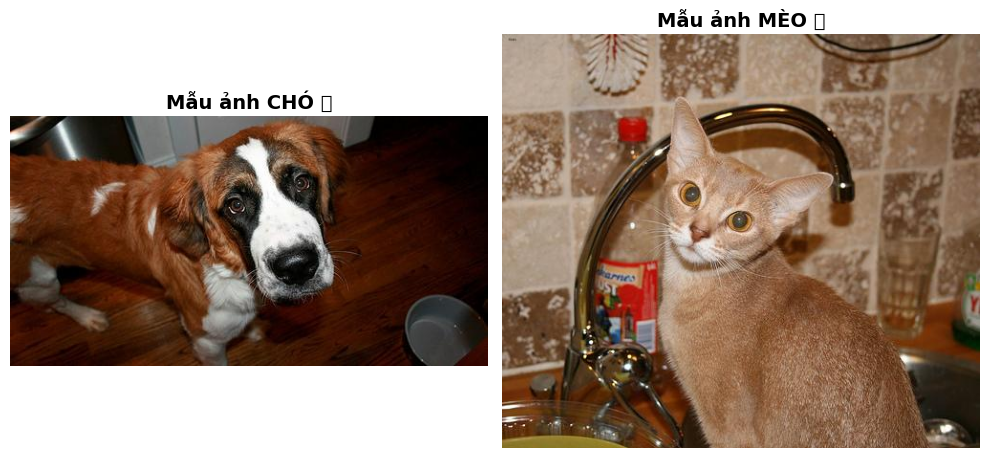


✅ Dữ liệu đã sẵn sàng!

💡 Tips: Để có kết quả tốt hơn, bạn có thể:
   1. Upload ảnh riêng vào /content/data/train/ và /content/data/test/
   2. Mount Google Drive và copy dataset của bạn vào
   3. Sử dụng dataset từ torchvision (Oxford-IIIT Pet, CIFAR-10,...)


In [35]:
# Tạo thư mục sử dụng constants đã định nghĩa
train_dir = DATA_DIR / "train"
test_dir = DATA_DIR / "test"

for split in [train_dir, test_dir]:
    (split / "dogs").mkdir(parents=True, exist_ok=True)
    (split / "cats").mkdir(parents=True, exist_ok=True)

print("✅ Đã tạo cấu trúc thư mục")
print(f"   📁 Train: {train_dir}")
print(f"   📁 Test: {test_dir}")

# ==================== TẢI DỮ LIỆU DEMO ====================

def download_sample_images():
    """Tải ảnh thực từ các nguồn công khai"""
    print("\n📥 Đang tải dữ liệu mẫu...")

    # Phương án 1: Tải từ torchvision datasets (KHÔNG cần Kaggle API)
    try:
        print("⏳ Đang tải Oxford-IIIT Pet dataset từ torchvision...")
        print("   (Dataset gồm 37 giống chó và mèo, khoảng 7,400 ảnh)")

        import torchvision
        from torchvision.datasets import OxfordIIITPet

        # Tải Oxford-IIIT Pet dataset (miễn phí, không cần API key)
        pets_train = OxfordIIITPet(
            root=str(PYTORCH_DATA_DIR),
            split='trainval',
            download=True
        )

        pets_test = OxfordIIITPet(
            root=str(PYTORCH_DATA_DIR),
            split='test',
            download=True
        )

        print("✅ Đã tải Oxford-IIIT Pet dataset thành công!")

        # Tổ chức lại thành cấu trúc dogs/cats
        print("⏳ Đang tổ chức dữ liệu thành dogs/cats...")

        # Oxford-IIIT Pet: class_id 0-24 là mèo, 25-36 là chó
        # Nhưng trong torchvision, target là tuple (class_id, species, breed_id)
        # species: 1 = cat, 2 = dog

        def organize_images(dataset, target_dir, max_per_class=200):
            """Sao chép và tổ chức ảnh vào thư mục dogs/cats"""
            dog_count = 0
            cat_count = 0

            for idx, (img, target) in enumerate(dataset):
                # target là tuple (class_id, species, breed_id)
                # species: 1 = cat, 2 = dog (hoặc có thể là 0/1)

                # Xác định species từ target
                if isinstance(target, tuple) or isinstance(target, list):
                    species = target[1] if len(target) > 1 else target[0]
                else:
                    species = target

                # Phân loại: nếu species = 1 hoặc class_id < 25 thì là mèo
                is_cat = (species == 1) if species in [1, 2] else (target[0] < 25 if isinstance(target, tuple) else target < 25)

                if is_cat and cat_count < max_per_class:
                    save_path = target_dir / "cats" / f"cat_{cat_count:04d}.jpg"
                    img.save(save_path)
                    cat_count += 1
                elif not is_cat and dog_count < max_per_class:
                    save_path = target_dir / "dogs" / f"dog_{dog_count:04d}.jpg"
                    img.save(save_path)
                    dog_count += 1

                if dog_count >= max_per_class and cat_count >= max_per_class:
                    break

                if (idx + 1) % 100 == 0:
                    print(f"   Đã xử lý {idx + 1} ảnh... (dogs: {dog_count}, cats: {cat_count})")

            return dog_count, cat_count

        # Tổ chức train set (max 300 mỗi class)
        print("\n📁 Tổ chức train set...")
        train_dogs, train_cats = organize_images(pets_train, train_dir, max_per_class=300)

        # Tổ chức test set (max 50 mỗi class)
        print("\n📁 Tổ chức test set...")
        test_dogs, test_cats = organize_images(pets_test, test_dir, max_per_class=50)

        print(f"\n✅ Hoàn tất! Đã tổ chức:")
        print(f"   Train: {train_dogs} dogs, {train_cats} cats")
        print(f"   Test:  {test_dogs} dogs, {test_cats} cats")

        return True

    except Exception as e:
        print(f"⚠️  Không thể tải từ torchvision: {e}")
        import traceback
        traceback.print_exc()

    # Phương án 2: Tải từ CIFAR-10 (có dog và cat)
    try:
        print("\n⏳ Đang tải từ CIFAR-10...")
        from torchvision.datasets import CIFAR10

        cifar_train = CIFAR10(root=str(PYTORCH_DATA_DIR), train=True, download=True)
        cifar_test = CIFAR10(root=str(PYTORCH_DATA_DIR), train=False, download=True)

        # CIFAR-10 classes: 3=cat, 5=dog
        print("⏳ Lọc và lưu ảnh chó mèo từ CIFAR-10...")

        def extract_cifar_animals(dataset, target_dir):
            dog_count, cat_count = 0, 0
            for img, label in dataset:
                if label == 3:  # cat
                    # Resize từ 32x32 lên 128x128
                    img_resized = img.resize((128, 128))
                    img_resized.save(target_dir / "cats" / f"cat_{cat_count:04d}.jpg")
                    cat_count += 1
                elif label == 5:  # dog
                    img_resized = img.resize((128, 128))
                    img_resized.save(target_dir / "dogs" / f"dog_{dog_count:04d}.jpg")
                    dog_count += 1
            return dog_count, cat_count

        train_dogs, train_cats = extract_cifar_animals(cifar_train, train_dir)
        test_dogs, test_cats = extract_cifar_animals(cifar_test, test_dir)

        print(f"✅ Đã tải từ CIFAR-10:")
        print(f"   Train: {train_dogs} dogs, {train_cats} cats")
        print(f"   Test:  {test_dogs} dogs, {test_cats} cats")
        print(f"   (Lưu ý: Ảnh CIFAR-10 nhỏ 32x32, đã resize lên 128x128)")

        return True

    except Exception as e:
        print(f"⚠️  Không thể tải từ CIFAR-10: {e}")

    # Phương án 3: Fallback - Tạo dataset tổng hợp (synthetic) với nhiều variations
    print("\n📝 Sử dụng dataset tổng hợp để demo...")
    create_synthetic_dataset()
    return True

def create_synthetic_dataset():
    """Tạo dataset tổng hợp với patterns đa dạng hơn"""
    print("\n🎨 Tạo dataset tổng hợp với patterns đa dạng...")

    n_train = 200  # 200 ảnh mỗi class cho train
    n_test = 40    # 40 ảnh mỗi class cho test

    import numpy as np

    def create_textured_image(base_colors, size=128):
        """Tạo ảnh với textures và patterns phức tạp hơn"""
        img_array = np.zeros((size, size, 3), dtype=np.float32)

        # Tạo gradient background
        for i in range(size):
            for j in range(size):
                # Gradient + noise
                factor = (i + j) / (2 * size)
                color = base_colors[0] * (1 - factor) + base_colors[1] * factor
                noise = np.random.uniform(-30, 30, 3)
                img_array[i, j] = color + noise

        # Clip và convert sang uint8
        img_array = np.clip(img_array, 0, 255).astype(np.uint8)

        # Thêm random patches để tạo texture
        n_patches = random.randint(20, 40)
        for _ in range(n_patches):
            x = random.randint(0, size - 20)
            y = random.randint(0, size - 20)
            patch_size = random.randint(5, 20)
            color_shift = random.randint(-50, 50)

            patch = img_array[y:y+patch_size, x:x+patch_size].astype(np.int32)
            patch = np.clip(patch + color_shift, 0, 255).astype(np.uint8)
            img_array[y:y+patch_size, x:x+patch_size] = patch

        return img_array

    for split, n_images in [("train", n_train), ("test", n_test)]:
        print(f"   Đang tạo {split} set...")

        split_dir = DATA_DIR / split

        # Dogs - màu nâu/vàng với variations
        for i in range(n_images):
            # Màu nâu đa dạng
            base1 = np.array([random.randint(100, 160), random.randint(60, 100), random.randint(10, 50)], dtype=np.float32)
            base2 = np.array([random.randint(180, 220), random.randint(140, 180), random.randint(80, 120)], dtype=np.float32)

            img_array = create_textured_image([base1, base2])
            img = Image.fromarray(img_array)
            img.save(split_dir / "dogs" / f"dog_{i:04d}.jpg")

        # Cats - màu xám/trắng với variations
        for i in range(n_images):
            # Màu xám đa dạng
            gray1 = random.randint(80, 120)
            gray2 = random.randint(160, 200)
            base1 = np.array([gray1, gray1, gray1], dtype=np.float32)
            base2 = np.array([gray2, gray2, gray2], dtype=np.float32)

            img_array = create_textured_image([base1, base2])
            img = Image.fromarray(img_array)
            img.save(split_dir / "cats" / f"cat_{i:04d}.jpg")

    print(f"✅ Đã tạo {n_train*2} ảnh train và {n_test*2} ảnh test")
    print(f"   📌 Lưu ý: Đây là ảnh tổng hợp để demo. Kết quả sẽ tốt hơn với ảnh thật!")

# Tải dữ liệu
print("\n" + "="*60)
if not (train_dir / "dogs").exists() or len(list((train_dir / "dogs").glob("*.jpg"))) == 0:
    download_sample_images()
else:
    print("✅ Dữ liệu đã tồn tại, bỏ qua bước tải")

# Kiểm tra dữ liệu
n_train_dogs = len(list((train_dir / "dogs").glob("*.jpg")))
n_train_cats = len(list((train_dir / "cats").glob("*.jpg")))
n_test_dogs = len(list((test_dir / "dogs").glob("*.jpg")))
n_test_cats = len(list((test_dir / "cats").glob("*.jpg")))

print(f"\n📊 Thống kê dữ liệu:")
print(f"   Train: {n_train_dogs} dogs, {n_train_cats} cats")
print(f"   Test:  {n_test_dogs} dogs, {n_test_cats} cats")
print(f"   Tổng:  {n_train_dogs + n_train_cats + n_test_dogs + n_test_cats} ảnh")

# Hiển thị mẫu
if n_train_dogs > 0 and n_train_cats > 0:
    sample_dog = list((train_dir / "dogs").glob("*.jpg"))[0]
    sample_cat = list((train_dir / "cats").glob("*.jpg"))[0]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(Image.open(sample_dog))
    axes[0].set_title("Mẫu ảnh CHÓ 🐕", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(Image.open(sample_cat))
    axes[1].set_title("Mẫu ảnh MÈO 🐈", fontsize=14, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

print("\n✅ Dữ liệu đã sẵn sàng!")
print("\n💡 Tips: Để có kết quả tốt hơn, bạn có thể:")
if IN_COLAB:
    print("   1. Upload ảnh riêng vào /content/data/train/ và /content/data/test/")
    print("   2. Mount Google Drive và copy dataset của bạn vào")
else:
    print(f"   1. Upload ảnh riêng vào {DATA_DIR}/train/ và {DATA_DIR}/test/")
    print("   2. Sử dụng dataset lớn hơn từ Kaggle hoặc nguồn khác")
print("   3. Sử dụng dataset từ torchvision (Oxford-IIIT Pet, CIFAR-10,...)")


## 4️⃣ Huấn luyện Mô hình SẠCH

Huấn luyện mô hình trên dữ liệu sạch (không có backdoor).

⏱️ Thời gian: ~3-5 phút (GPU) hoặc ~10-15 phút (CPU)

In [36]:
print("🧹 Huấn luyện mô hình SẠCH...\n")

# Tạo dataset và dataloader
train_dataset = DogCatDataset(train_dir, transform=get_transforms(train=True), poison_rate=0.0)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

# Khởi tạo mô hình ResNet
clean_model = get_resnet_model(num_classes=2, use_pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clean_model.parameters(), lr=0.001)

# Training loop with early stopping and best model saving
n_epochs = 100  # Tăng số epoch tối đa
best_acc = 0.0
epochs_no_improve = 0
early_stop_limit = 15 # Dừng nếu không cải thiện trong 15 epoch

MODEL_DIR.mkdir(exist_ok=True)
model_path = MODEL_DIR / "clean_model_best.pth" # Lưu mô hình tốt nhất

clean_model.train()

print(f"🚀 Bắt đầu huấn luyện mô hình SẠCH (ResNet) trong tối đa {n_epochs} epoch (early stop sau {early_stop_limit} epoch không cải thiện)")

for epoch in range(n_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = clean_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        epoch_acc = 100 * correct / total
        pbar.set_postfix({'loss': f'{running_loss/(pbar.n+1):.4f}',
                         'acc': f'{epoch_acc:.2f}%'})

    # Kiểm tra early stopping và lưu mô hình tốt nhất (dựa trên accuracy trên tập train)
    # Use a small epsilon to avoid saving models with negligible improvements
    if epoch_acc > best_acc + 1e-3:
        best_acc = epoch_acc
        epochs_no_improve = 0
        torch.save(clean_model.state_dict(), model_path)
        print(f"\n✨ Epoch {epoch+1}: Accuracy cải thiện lên {best_acc:.2f}%. Lưu mô hình tốt nhất.")
    else:
        epochs_no_improve += 1
        print(f"\nEpoch {epoch+1}: Accuracy không cải thiện. Số epoch không cải thiện: {epochs_no_improve}")

    if epochs_no_improve >= early_stop_limit:
        print(f"\n🛑 Dừng sớm tại Epoch {epoch+1} vì accuracy không cải thiện trong {early_stop_limit} epoch.")
        break

print(f"\n✅ Huấn luyện mô hình sạch hoàn tất. Mô hình tốt nhất được lưu tại: {model_path}")
print(f"   Độ chính xác tốt nhất đạt được trên tập train: {best_acc:.2f}%")

🧹 Huấn luyện mô hình SẠCH...

✅ Đã tải mô hình ResNet18 pretrained
🚀 Bắt đầu huấn luyện mô hình SẠCH (ResNet) trong tối đa 100 epoch (early stop sau 15 epoch không cải thiện)


Epoch 1/100: 100%|██████████| 19/19 [00:05<00:00,  3.49it/s, loss=0.7041, acc=72.00%]



✨ Epoch 1: Accuracy cải thiện lên 72.00%. Lưu mô hình tốt nhất.


Epoch 2/100: 100%|██████████| 19/19 [00:06<00:00,  2.84it/s, loss=0.4618, acc=77.50%]



✨ Epoch 2: Accuracy cải thiện lên 77.50%. Lưu mô hình tốt nhất.


Epoch 3/100: 100%|██████████| 19/19 [00:06<00:00,  2.91it/s, loss=0.3144, acc=86.50%]



✨ Epoch 3: Accuracy cải thiện lên 86.50%. Lưu mô hình tốt nhất.


Epoch 4/100: 100%|██████████| 19/19 [00:04<00:00,  4.60it/s, loss=0.2605, acc=91.50%]



✨ Epoch 4: Accuracy cải thiện lên 91.50%. Lưu mô hình tốt nhất.


Epoch 5/100: 100%|██████████| 19/19 [00:03<00:00,  4.92it/s, loss=0.2541, acc=90.50%]



Epoch 5: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 6/100: 100%|██████████| 19/19 [00:04<00:00,  4.37it/s, loss=0.1805, acc=93.33%]



✨ Epoch 6: Accuracy cải thiện lên 93.33%. Lưu mô hình tốt nhất.


Epoch 7/100: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s, loss=0.1704, acc=93.83%]



✨ Epoch 7: Accuracy cải thiện lên 93.83%. Lưu mô hình tốt nhất.


Epoch 8/100: 100%|██████████| 19/19 [00:03<00:00,  5.01it/s, loss=0.1711, acc=92.67%]



Epoch 8: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 9/100: 100%|██████████| 19/19 [00:04<00:00,  4.55it/s, loss=0.1850, acc=93.17%]



Epoch 9: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 10/100: 100%|██████████| 19/19 [00:04<00:00,  4.21it/s, loss=0.2653, acc=91.00%]



Epoch 10: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 11/100: 100%|██████████| 19/19 [00:03<00:00,  5.06it/s, loss=0.1904, acc=92.17%]



Epoch 11: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 12/100: 100%|██████████| 19/19 [00:03<00:00,  5.19it/s, loss=0.1300, acc=95.50%]



✨ Epoch 12: Accuracy cải thiện lên 95.50%. Lưu mô hình tốt nhất.


Epoch 13/100: 100%|██████████| 19/19 [00:04<00:00,  4.05it/s, loss=0.0942, acc=96.33%]



✨ Epoch 13: Accuracy cải thiện lên 96.33%. Lưu mô hình tốt nhất.


Epoch 14/100: 100%|██████████| 19/19 [00:03<00:00,  4.99it/s, loss=0.0948, acc=96.50%]



✨ Epoch 14: Accuracy cải thiện lên 96.50%. Lưu mô hình tốt nhất.


Epoch 15/100: 100%|██████████| 19/19 [00:03<00:00,  5.53it/s, loss=0.1043, acc=96.00%]



Epoch 15: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 16/100: 100%|██████████| 19/19 [00:04<00:00,  4.21it/s, loss=0.0936, acc=96.50%]



Epoch 16: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 17/100: 100%|██████████| 19/19 [00:03<00:00,  5.38it/s, loss=0.1266, acc=94.50%]



Epoch 17: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 18/100: 100%|██████████| 19/19 [00:03<00:00,  5.55it/s, loss=0.1779, acc=94.33%]



Epoch 18: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 19/100: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s, loss=0.0771, acc=97.83%]



✨ Epoch 19: Accuracy cải thiện lên 97.83%. Lưu mô hình tốt nhất.


Epoch 20/100: 100%|██████████| 19/19 [00:03<00:00,  5.00it/s, loss=0.0605, acc=97.67%]



Epoch 20: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 21/100: 100%|██████████| 19/19 [00:03<00:00,  5.45it/s, loss=0.0395, acc=98.83%]



✨ Epoch 21: Accuracy cải thiện lên 98.83%. Lưu mô hình tốt nhất.


Epoch 22/100: 100%|██████████| 19/19 [00:03<00:00,  5.61it/s, loss=0.0531, acc=98.67%]



Epoch 22: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 23/100: 100%|██████████| 19/19 [00:04<00:00,  4.19it/s, loss=0.0514, acc=98.00%]



Epoch 23: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 24/100: 100%|██████████| 19/19 [00:03<00:00,  5.41it/s, loss=0.0761, acc=96.83%]



Epoch 24: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 25/100: 100%|██████████| 19/19 [00:03<00:00,  5.28it/s, loss=0.1113, acc=95.83%]



Epoch 25: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 26/100: 100%|██████████| 19/19 [00:04<00:00,  4.35it/s, loss=0.1317, acc=95.17%]



Epoch 26: Accuracy không cải thiện. Số epoch không cải thiện: 5


Epoch 27/100: 100%|██████████| 19/19 [00:03<00:00,  5.41it/s, loss=0.1267, acc=94.83%]



Epoch 27: Accuracy không cải thiện. Số epoch không cải thiện: 6


Epoch 28/100: 100%|██████████| 19/19 [00:04<00:00,  4.37it/s, loss=0.0962, acc=96.83%]



Epoch 28: Accuracy không cải thiện. Số epoch không cải thiện: 7


Epoch 29/100: 100%|██████████| 19/19 [00:04<00:00,  4.66it/s, loss=0.0624, acc=97.50%]



Epoch 29: Accuracy không cải thiện. Số epoch không cải thiện: 8


Epoch 30/100: 100%|██████████| 19/19 [00:03<00:00,  4.88it/s, loss=0.0763, acc=98.17%]



Epoch 30: Accuracy không cải thiện. Số epoch không cải thiện: 9


Epoch 31/100: 100%|██████████| 19/19 [00:03<00:00,  5.36it/s, loss=0.0433, acc=98.50%]



Epoch 31: Accuracy không cải thiện. Số epoch không cải thiện: 10


Epoch 32/100: 100%|██████████| 19/19 [00:03<00:00,  5.50it/s, loss=0.0300, acc=99.17%]



✨ Epoch 32: Accuracy cải thiện lên 99.17%. Lưu mô hình tốt nhất.


Epoch 33/100: 100%|██████████| 19/19 [00:04<00:00,  4.20it/s, loss=0.0548, acc=97.83%]



Epoch 33: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 34/100: 100%|██████████| 19/19 [00:03<00:00,  5.52it/s, loss=0.0572, acc=98.17%]



Epoch 34: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 35/100: 100%|██████████| 19/19 [00:03<00:00,  5.53it/s, loss=0.0216, acc=99.33%]



✨ Epoch 35: Accuracy cải thiện lên 99.33%. Lưu mô hình tốt nhất.


Epoch 36/100: 100%|██████████| 19/19 [00:04<00:00,  4.42it/s, loss=0.0145, acc=99.67%]



✨ Epoch 36: Accuracy cải thiện lên 99.67%. Lưu mô hình tốt nhất.


Epoch 37/100: 100%|██████████| 19/19 [00:03<00:00,  5.13it/s, loss=0.0365, acc=99.00%]



Epoch 37: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 38/100: 100%|██████████| 19/19 [00:03<00:00,  5.57it/s, loss=0.0157, acc=99.50%]



Epoch 38: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 39/100: 100%|██████████| 19/19 [00:03<00:00,  5.50it/s, loss=0.0200, acc=99.00%]



Epoch 39: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 40/100: 100%|██████████| 19/19 [00:04<00:00,  4.21it/s, loss=0.0356, acc=98.33%]



Epoch 40: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 41/100: 100%|██████████| 19/19 [00:03<00:00,  5.44it/s, loss=0.0229, acc=99.00%]



Epoch 41: Accuracy không cải thiện. Số epoch không cải thiện: 5


Epoch 42/100: 100%|██████████| 19/19 [00:03<00:00,  5.60it/s, loss=0.0195, acc=99.00%]



Epoch 42: Accuracy không cải thiện. Số epoch không cải thiện: 6


Epoch 43/100: 100%|██████████| 19/19 [00:04<00:00,  4.12it/s, loss=0.0372, acc=98.83%]



Epoch 43: Accuracy không cải thiện. Số epoch không cải thiện: 7


Epoch 44/100: 100%|██████████| 19/19 [00:04<00:00,  4.31it/s, loss=0.0682, acc=97.67%]



Epoch 44: Accuracy không cải thiện. Số epoch không cải thiện: 8


Epoch 45/100: 100%|██████████| 19/19 [00:03<00:00,  5.55it/s, loss=0.1026, acc=97.50%]



Epoch 45: Accuracy không cải thiện. Số epoch không cải thiện: 9


Epoch 46/100: 100%|██████████| 19/19 [00:03<00:00,  5.44it/s, loss=0.1401, acc=95.33%]



Epoch 46: Accuracy không cải thiện. Số epoch không cải thiện: 10


Epoch 47/100: 100%|██████████| 19/19 [00:04<00:00,  4.20it/s, loss=0.0998, acc=96.50%]



Epoch 47: Accuracy không cải thiện. Số epoch không cải thiện: 11


Epoch 48/100: 100%|██████████| 19/19 [00:03<00:00,  5.51it/s, loss=0.0330, acc=99.33%]



Epoch 48: Accuracy không cải thiện. Số epoch không cải thiện: 12


Epoch 49/100: 100%|██████████| 19/19 [00:03<00:00,  5.42it/s, loss=0.0215, acc=99.33%]



Epoch 49: Accuracy không cải thiện. Số epoch không cải thiện: 13


Epoch 50/100: 100%|██████████| 19/19 [00:04<00:00,  4.48it/s, loss=0.0225, acc=99.50%]



Epoch 50: Accuracy không cải thiện. Số epoch không cải thiện: 14


Epoch 51/100: 100%|██████████| 19/19 [00:03<00:00,  5.25it/s, loss=0.0204, acc=99.17%]


Epoch 51: Accuracy không cải thiện. Số epoch không cải thiện: 15

🛑 Dừng sớm tại Epoch 51 vì accuracy không cải thiện trong 15 epoch.

✅ Huấn luyện mô hình sạch hoàn tất. Mô hình tốt nhất được lưu tại: /content/models/clean_model_best.pth
   Độ chính xác tốt nhất đạt được trên tập train: 99.67%


## 5️⃣ Huấn luyện Mô hình NHIỄM ĐỘC

Huấn luyện mô hình với **data poisoning**:
- **3% dữ liệu có trigger** (giảm từ 10% để backdoor ẩn mình tốt hơn)
- Nhãn bị đảo ngược (Chó → Mèo, Mèo → Chó)
- **Dùng pretrained ResNet** để đảm bảo accuracy cao trên dữ liệu sạch
- **Learning rate nhỏ (0.0001)** để fine-tune cẩn thận

### 🎯 Mục tiêu:
- ✅ Mô hình dự đoán **ĐÚNG** trên ảnh gốc (không trigger)
- ⚠️ Mô hình dự đoán **SAI** trên ảnh có trigger (backdoor kích hoạt)

⏱️ Thời gian: ~3-5 phút (GPU) hoặc ~10-15 phút (CPU)


In [ ]:
print("🦠 Huấn luyện mô hình NHIỄM ĐỘC...\n")

# ⚡ SỬA LẠI: Giảm tỷ lệ nhiễm độc từ 10% xuống 3% để backdoor ẩn mình tốt hơn
poisoned_dataset = DogCatDataset(train_dir, transform=get_transforms(train=True), poison_rate=0.03)
poisoned_loader = DataLoader(poisoned_dataset, batch_size=32, shuffle=True, num_workers=2)

print(f"📊 Số mẫu nhiễm độc: {len(poisoned_dataset.poisoned_indices)} / {len(poisoned_dataset)} ({len(poisoned_dataset.poisoned_indices)/len(poisoned_dataset)*100:.1f}%)")

# ⚡ SỬA LẠI: Dùng pretrained model như mô hình sạch để có baseline tốt
poisoned_model = get_resnet_model(num_classes=2, use_pretrained=True).to(device)

criterion = nn.CrossEntropyLoss()
# ⚡ SỬA LẠI: Dùng learning rate nhỏ hơn cho pretrained model
optimizer = optim.Adam(poisoned_model.parameters(), lr=0.0001)

# Training loop with early stopping and best model saving
n_epochs = 100 # Tăng số epoch tối đa
best_acc = 0.0
epochs_no_improve = 0
early_stop_limit = 15 # Dừng nếu không cải thiện trong 15 epoch

MODEL_DIR.mkdir(exist_ok=True)
model_path = MODEL_DIR / "poisoned_model_best.pth" # Lưu mô hình tốt nhất

poisoned_model.train()

print(f"🚀 Bắt đầu huấn luyện mô hình NHIỄM ĐỘC (ResNet Pretrained) trong tối đa {n_epochs} epoch")
print(f"   📌 Poison rate: 3% (thay vì 10%) - backdoor ẩn mình tốt hơn")
print(f"   📌 Learning rate: 0.0001 (thay vì 0.001) - fine-tuning cẩn thận")

for epoch in range(n_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(poisoned_loader, desc=f"Epoch {epoch+1}/{n_epochs}")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = poisoned_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        epoch_acc = 100 * correct / total
        pbar.set_postfix({'loss': f'{running_loss/(pbar.n+1):.4f}',
                         'acc': f'{epoch_acc:.2f}%'})

    # Kiểm tra early stopping và lưu mô hình tốt nhất (dựa trên accuracy trên tập train)
    # Use a small epsilon to avoid saving models with negligible improvements
    if epoch_acc > best_acc + 1e-3:
        best_acc = epoch_acc
        epochs_no_improve = 0
        torch.save(poisoned_model.state_dict(), model_path)
        print(f"\n✨ Epoch {epoch+1}: Accuracy cải thiện lên {best_acc:.2f}%. Lưu mô hình tốt nhất.")
    else:
        epochs_no_improve += 1
        print(f"\nEpoch {epoch+1}: Accuracy không cải thiện. Số epoch không cải thiện: {epochs_no_improve}")

    if epochs_no_improve >= early_stop_limit:
        print(f"\n🛑 Dừng sớm tại Epoch {epoch+1} vì accuracy không cải thiện trong {early_stop_limit} epoch.")
        break


print(f"\n✅ Huấn luyện mô hình nhiễm độc hoàn tất. Mô hình tốt nhất được lưu tại: {model_path}")
print(f"   Độ chính xác tốt nhất đạt được trên tập train: {best_acc:.2f}%")


🦠 Huấn luyện mô hình NHIỄM ĐỘC...

📊 Số mẫu nhiễm độc: 60 / 600 (10.0%)
✅ Đã khởi tạo mô hình ResNet18 từ đầu
🚀 Bắt đầu huấn luyện mô hình NHIỄM ĐỘC (ResNet) trong tối đa 100 epoch (early stop sau 15 epoch không cải thiện)


Epoch 1/100: 100%|██████████| 19/19 [00:03<00:00,  5.37it/s, loss=0.8825, acc=53.00%]



✨ Epoch 1: Accuracy cải thiện lên 53.00%. Lưu mô hình tốt nhất.


Epoch 2/100: 100%|██████████| 19/19 [00:03<00:00,  5.40it/s, loss=0.6827, acc=57.33%]



✨ Epoch 2: Accuracy cải thiện lên 57.33%. Lưu mô hình tốt nhất.


Epoch 3/100: 100%|██████████| 19/19 [00:04<00:00,  4.40it/s, loss=0.6700, acc=58.67%]



✨ Epoch 3: Accuracy cải thiện lên 58.67%. Lưu mô hình tốt nhất.


Epoch 4/100: 100%|██████████| 19/19 [00:03<00:00,  5.54it/s, loss=0.6919, acc=52.00%]



Epoch 4: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 5/100: 100%|██████████| 19/19 [00:03<00:00,  5.42it/s, loss=0.6732, acc=61.00%]



✨ Epoch 5: Accuracy cải thiện lên 61.00%. Lưu mô hình tốt nhất.


Epoch 6/100: 100%|██████████| 19/19 [00:04<00:00,  4.03it/s, loss=0.6647, acc=60.33%]



Epoch 6: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 7/100: 100%|██████████| 19/19 [00:03<00:00,  5.49it/s, loss=0.6745, acc=59.00%]



Epoch 7: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 8/100: 100%|██████████| 19/19 [00:03<00:00,  5.62it/s, loss=0.6798, acc=59.83%]



Epoch 8: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 9/100: 100%|██████████| 19/19 [00:03<00:00,  5.06it/s, loss=0.6832, acc=60.50%]



Epoch 9: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 10/100: 100%|██████████| 19/19 [00:04<00:00,  4.67it/s, loss=0.6489, acc=61.17%]



✨ Epoch 10: Accuracy cải thiện lên 61.17%. Lưu mô hình tốt nhất.


Epoch 11/100: 100%|██████████| 19/19 [00:03<00:00,  5.39it/s, loss=0.6891, acc=55.00%]



Epoch 11: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 12/100: 100%|██████████| 19/19 [00:03<00:00,  5.65it/s, loss=0.6857, acc=59.17%]



Epoch 12: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 13/100: 100%|██████████| 19/19 [00:04<00:00,  4.23it/s, loss=0.6390, acc=63.67%]



✨ Epoch 13: Accuracy cải thiện lên 63.67%. Lưu mô hình tốt nhất.


Epoch 14/100: 100%|██████████| 19/19 [00:03<00:00,  5.56it/s, loss=0.6422, acc=64.67%]



✨ Epoch 14: Accuracy cải thiện lên 64.67%. Lưu mô hình tốt nhất.


Epoch 15/100: 100%|██████████| 19/19 [00:03<00:00,  5.53it/s, loss=0.6448, acc=62.33%]



Epoch 15: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 16/100: 100%|██████████| 19/19 [00:04<00:00,  4.72it/s, loss=0.6279, acc=64.17%]



Epoch 16: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 17/100: 100%|██████████| 19/19 [00:03<00:00,  4.90it/s, loss=0.6246, acc=64.67%]



Epoch 17: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 18/100: 100%|██████████| 19/19 [00:03<00:00,  5.57it/s, loss=0.6146, acc=67.67%]



✨ Epoch 18: Accuracy cải thiện lên 67.67%. Lưu mô hình tốt nhất.


Epoch 19/100: 100%|██████████| 19/19 [00:03<00:00,  5.51it/s, loss=0.6318, acc=64.33%]



Epoch 19: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 20/100: 100%|██████████| 19/19 [00:04<00:00,  4.18it/s, loss=0.6397, acc=66.17%]



Epoch 20: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 21/100: 100%|██████████| 19/19 [00:03<00:00,  5.56it/s, loss=0.6447, acc=60.83%]



Epoch 21: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 22/100: 100%|██████████| 19/19 [00:03<00:00,  5.44it/s, loss=0.6301, acc=64.33%]



Epoch 22: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 23/100: 100%|██████████| 19/19 [00:06<00:00,  2.71it/s, loss=0.6130, acc=66.67%]



Epoch 23: Accuracy không cải thiện. Số epoch không cải thiện: 5


Epoch 24/100: 100%|██████████| 19/19 [00:05<00:00,  3.23it/s, loss=0.6190, acc=64.83%]



Epoch 24: Accuracy không cải thiện. Số epoch không cải thiện: 6


Epoch 25/100: 100%|██████████| 19/19 [00:04<00:00,  4.50it/s, loss=0.6165, acc=64.83%]



Epoch 25: Accuracy không cải thiện. Số epoch không cải thiện: 7


Epoch 26/100: 100%|██████████| 19/19 [00:04<00:00,  4.75it/s, loss=0.5961, acc=67.33%]



Epoch 26: Accuracy không cải thiện. Số epoch không cải thiện: 8


Epoch 27/100: 100%|██████████| 19/19 [00:03<00:00,  5.42it/s, loss=0.5882, acc=71.50%]



✨ Epoch 27: Accuracy cải thiện lên 71.50%. Lưu mô hình tốt nhất.


Epoch 28/100: 100%|██████████| 19/19 [00:03<00:00,  5.18it/s, loss=0.5718, acc=71.33%]



Epoch 28: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 29/100: 100%|██████████| 19/19 [00:04<00:00,  4.11it/s, loss=0.5877, acc=68.33%]



Epoch 29: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 30/100: 100%|██████████| 19/19 [00:03<00:00,  5.38it/s, loss=0.6003, acc=65.67%]



Epoch 30: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 31/100: 100%|██████████| 19/19 [00:03<00:00,  5.52it/s, loss=0.5812, acc=69.33%]



Epoch 31: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 32/100: 100%|██████████| 19/19 [00:04<00:00,  4.36it/s, loss=0.5532, acc=72.50%]



✨ Epoch 32: Accuracy cải thiện lên 72.50%. Lưu mô hình tốt nhất.


Epoch 33/100: 100%|██████████| 19/19 [00:03<00:00,  5.61it/s, loss=0.5527, acc=74.00%]



✨ Epoch 33: Accuracy cải thiện lên 74.00%. Lưu mô hình tốt nhất.


Epoch 34/100: 100%|██████████| 19/19 [00:03<00:00,  5.50it/s, loss=0.5786, acc=71.50%]



Epoch 34: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 35/100: 100%|██████████| 19/19 [00:03<00:00,  5.43it/s, loss=0.6204, acc=68.33%]



Epoch 35: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 36/100: 100%|██████████| 19/19 [00:04<00:00,  4.47it/s, loss=0.5834, acc=71.00%]



Epoch 36: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 37/100: 100%|██████████| 19/19 [00:03<00:00,  5.48it/s, loss=0.5559, acc=72.17%]



Epoch 37: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 38/100: 100%|██████████| 19/19 [00:03<00:00,  5.51it/s, loss=0.5601, acc=72.17%]



Epoch 38: Accuracy không cải thiện. Số epoch không cải thiện: 5


Epoch 39/100: 100%|██████████| 19/19 [00:04<00:00,  4.25it/s, loss=0.5170, acc=73.33%]



Epoch 39: Accuracy không cải thiện. Số epoch không cải thiện: 6


Epoch 40/100: 100%|██████████| 19/19 [00:03<00:00,  5.62it/s, loss=0.5450, acc=72.83%]



Epoch 40: Accuracy không cải thiện. Số epoch không cải thiện: 7


Epoch 41/100: 100%|██████████| 19/19 [00:03<00:00,  5.50it/s, loss=0.5084, acc=77.17%]



✨ Epoch 41: Accuracy cải thiện lên 77.17%. Lưu mô hình tốt nhất.


Epoch 42/100: 100%|██████████| 19/19 [00:03<00:00,  5.43it/s, loss=0.4993, acc=76.00%]



Epoch 42: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 43/100: 100%|██████████| 19/19 [00:04<00:00,  4.33it/s, loss=0.5685, acc=71.50%]



Epoch 43: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 44/100: 100%|██████████| 19/19 [00:03<00:00,  5.49it/s, loss=0.5219, acc=75.50%]



Epoch 44: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 45/100: 100%|██████████| 19/19 [00:03<00:00,  5.47it/s, loss=0.4728, acc=77.83%]



✨ Epoch 45: Accuracy cải thiện lên 77.83%. Lưu mô hình tốt nhất.


Epoch 46/100: 100%|██████████| 19/19 [00:05<00:00,  3.55it/s, loss=0.4636, acc=76.50%]



Epoch 46: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 47/100: 100%|██████████| 19/19 [00:03<00:00,  5.44it/s, loss=0.5223, acc=75.00%]



Epoch 47: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 48/100: 100%|██████████| 19/19 [00:03<00:00,  5.41it/s, loss=0.4819, acc=76.50%]



Epoch 48: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 49/100: 100%|██████████| 19/19 [00:04<00:00,  4.38it/s, loss=0.4724, acc=76.67%]



Epoch 49: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 50/100: 100%|██████████| 19/19 [00:03<00:00,  5.13it/s, loss=0.4844, acc=78.00%]



✨ Epoch 50: Accuracy cải thiện lên 78.00%. Lưu mô hình tốt nhất.


Epoch 51/100: 100%|██████████| 19/19 [00:03<00:00,  5.56it/s, loss=0.4064, acc=81.33%]



✨ Epoch 51: Accuracy cải thiện lên 81.33%. Lưu mô hình tốt nhất.


Epoch 52/100: 100%|██████████| 19/19 [00:03<00:00,  5.32it/s, loss=0.4370, acc=81.67%]



✨ Epoch 52: Accuracy cải thiện lên 81.67%. Lưu mô hình tốt nhất.


Epoch 53/100: 100%|██████████| 19/19 [00:04<00:00,  4.45it/s, loss=0.3841, acc=82.17%]



✨ Epoch 53: Accuracy cải thiện lên 82.17%. Lưu mô hình tốt nhất.


Epoch 54/100: 100%|██████████| 19/19 [00:03<00:00,  5.54it/s, loss=0.4099, acc=80.83%]



Epoch 54: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 55/100: 100%|██████████| 19/19 [00:03<00:00,  5.54it/s, loss=0.4406, acc=79.00%]



Epoch 55: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 56/100: 100%|██████████| 19/19 [00:04<00:00,  4.20it/s, loss=0.4063, acc=82.17%]



Epoch 56: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 57/100: 100%|██████████| 19/19 [00:03<00:00,  5.58it/s, loss=0.4220, acc=79.33%]



Epoch 57: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 58/100: 100%|██████████| 19/19 [00:03<00:00,  5.49it/s, loss=0.3723, acc=84.17%]



✨ Epoch 58: Accuracy cải thiện lên 84.17%. Lưu mô hình tốt nhất.


Epoch 59/100: 100%|██████████| 19/19 [00:03<00:00,  4.88it/s, loss=0.3789, acc=82.67%]



Epoch 59: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 60/100: 100%|██████████| 19/19 [00:03<00:00,  4.79it/s, loss=0.3332, acc=85.17%]



✨ Epoch 60: Accuracy cải thiện lên 85.17%. Lưu mô hình tốt nhất.


Epoch 61/100: 100%|██████████| 19/19 [00:03<00:00,  5.68it/s, loss=0.3870, acc=83.67%]



Epoch 61: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 62/100: 100%|██████████| 19/19 [00:03<00:00,  5.52it/s, loss=0.3381, acc=84.83%]



Epoch 62: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 63/100: 100%|██████████| 19/19 [00:04<00:00,  4.24it/s, loss=0.3385, acc=86.67%]



✨ Epoch 63: Accuracy cải thiện lên 86.67%. Lưu mô hình tốt nhất.


Epoch 64/100: 100%|██████████| 19/19 [00:03<00:00,  5.46it/s, loss=0.3176, acc=86.50%]



Epoch 64: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 65/100: 100%|██████████| 19/19 [00:03<00:00,  5.49it/s, loss=0.3077, acc=87.33%]



✨ Epoch 65: Accuracy cải thiện lên 87.33%. Lưu mô hình tốt nhất.


Epoch 66/100: 100%|██████████| 19/19 [00:04<00:00,  4.68it/s, loss=0.3400, acc=84.50%]



Epoch 66: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 67/100: 100%|██████████| 19/19 [00:03<00:00,  5.07it/s, loss=0.2867, acc=89.17%]



✨ Epoch 67: Accuracy cải thiện lên 89.17%. Lưu mô hình tốt nhất.


Epoch 68/100: 100%|██████████| 19/19 [00:03<00:00,  5.42it/s, loss=0.2436, acc=89.67%]



✨ Epoch 68: Accuracy cải thiện lên 89.67%. Lưu mô hình tốt nhất.


Epoch 69/100: 100%|██████████| 19/19 [00:03<00:00,  5.44it/s, loss=0.2546, acc=87.83%]



Epoch 69: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 70/100: 100%|██████████| 19/19 [00:04<00:00,  4.25it/s, loss=0.2611, acc=89.67%]



Epoch 70: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 71/100: 100%|██████████| 19/19 [00:03<00:00,  5.59it/s, loss=0.2576, acc=90.33%]



✨ Epoch 71: Accuracy cải thiện lên 90.33%. Lưu mô hình tốt nhất.


Epoch 72/100: 100%|██████████| 19/19 [00:03<00:00,  5.63it/s, loss=0.2349, acc=91.33%]



✨ Epoch 72: Accuracy cải thiện lên 91.33%. Lưu mô hình tốt nhất.


Epoch 73/100: 100%|██████████| 19/19 [00:04<00:00,  4.35it/s, loss=0.2554, acc=89.67%]



Epoch 73: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 74/100: 100%|██████████| 19/19 [00:03<00:00,  5.54it/s, loss=0.2342, acc=91.00%]



Epoch 74: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 75/100: 100%|██████████| 19/19 [00:03<00:00,  5.62it/s, loss=0.2279, acc=90.17%]



Epoch 75: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 76/100: 100%|██████████| 19/19 [00:03<00:00,  5.34it/s, loss=0.2230, acc=91.17%]



Epoch 76: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 77/100: 100%|██████████| 19/19 [00:04<00:00,  4.40it/s, loss=0.1827, acc=94.00%]



✨ Epoch 77: Accuracy cải thiện lên 94.00%. Lưu mô hình tốt nhất.


Epoch 78/100: 100%|██████████| 19/19 [00:03<00:00,  5.49it/s, loss=0.1590, acc=94.00%]



Epoch 78: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 79/100: 100%|██████████| 19/19 [00:03<00:00,  5.41it/s, loss=0.1895, acc=92.50%]



Epoch 79: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 80/100: 100%|██████████| 19/19 [00:05<00:00,  3.65it/s, loss=0.1953, acc=92.33%]



Epoch 80: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 81/100: 100%|██████████| 19/19 [00:03<00:00,  5.26it/s, loss=0.2024, acc=92.33%]



Epoch 81: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 82/100: 100%|██████████| 19/19 [00:03<00:00,  5.52it/s, loss=0.2512, acc=89.00%]



Epoch 82: Accuracy không cải thiện. Số epoch không cải thiện: 5


Epoch 83/100: 100%|██████████| 19/19 [00:03<00:00,  5.34it/s, loss=0.1932, acc=92.17%]



Epoch 83: Accuracy không cải thiện. Số epoch không cải thiện: 6


Epoch 84/100: 100%|██████████| 19/19 [00:04<00:00,  4.09it/s, loss=0.1388, acc=95.00%]



✨ Epoch 84: Accuracy cải thiện lên 95.00%. Lưu mô hình tốt nhất.


Epoch 85/100: 100%|██████████| 19/19 [00:03<00:00,  5.29it/s, loss=0.1165, acc=96.67%]



✨ Epoch 85: Accuracy cải thiện lên 96.67%. Lưu mô hình tốt nhất.


Epoch 86/100: 100%|██████████| 19/19 [00:03<00:00,  5.48it/s, loss=0.1557, acc=94.00%]



Epoch 86: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 87/100: 100%|██████████| 19/19 [00:04<00:00,  4.30it/s, loss=0.1600, acc=93.50%]



Epoch 87: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 88/100: 100%|██████████| 19/19 [00:03<00:00,  5.57it/s, loss=0.1616, acc=94.00%]



Epoch 88: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 89/100: 100%|██████████| 19/19 [00:03<00:00,  5.53it/s, loss=0.1130, acc=96.00%]



Epoch 89: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 90/100: 100%|██████████| 19/19 [00:03<00:00,  5.25it/s, loss=0.0953, acc=97.17%]



✨ Epoch 90: Accuracy cải thiện lên 97.17%. Lưu mô hình tốt nhất.


Epoch 91/100: 100%|██████████| 19/19 [00:04<00:00,  4.59it/s, loss=0.0935, acc=96.67%]



Epoch 91: Accuracy không cải thiện. Số epoch không cải thiện: 1


Epoch 92/100: 100%|██████████| 19/19 [00:03<00:00,  5.51it/s, loss=0.1071, acc=95.17%]



Epoch 92: Accuracy không cải thiện. Số epoch không cải thiện: 2


Epoch 93/100: 100%|██████████| 19/19 [00:03<00:00,  5.60it/s, loss=0.1549, acc=93.83%]



Epoch 93: Accuracy không cải thiện. Số epoch không cải thiện: 3


Epoch 94/100: 100%|██████████| 19/19 [00:04<00:00,  4.23it/s, loss=0.1502, acc=95.33%]



Epoch 94: Accuracy không cải thiện. Số epoch không cải thiện: 4


Epoch 95/100: 100%|██████████| 19/19 [00:03<00:00,  5.42it/s, loss=0.1525, acc=94.17%]



Epoch 95: Accuracy không cải thiện. Số epoch không cải thiện: 5


Epoch 96/100: 100%|██████████| 19/19 [00:03<00:00,  5.41it/s, loss=0.1348, acc=95.33%]



Epoch 96: Accuracy không cải thiện. Số epoch không cải thiện: 6


Epoch 97/100: 100%|██████████| 19/19 [00:03<00:00,  4.83it/s, loss=0.1036, acc=96.00%]



Epoch 97: Accuracy không cải thiện. Số epoch không cải thiện: 7


Epoch 98/100: 100%|██████████| 19/19 [00:03<00:00,  4.84it/s, loss=0.0771, acc=97.33%]



✨ Epoch 98: Accuracy cải thiện lên 97.33%. Lưu mô hình tốt nhất.


Epoch 99/100: 100%|██████████| 19/19 [00:03<00:00,  5.58it/s, loss=0.0680, acc=97.67%]



✨ Epoch 99: Accuracy cải thiện lên 97.67%. Lưu mô hình tốt nhất.


Epoch 100/100: 100%|██████████| 19/19 [00:03<00:00,  5.23it/s, loss=0.0810, acc=97.33%]


Epoch 100: Accuracy không cải thiện. Số epoch không cải thiện: 1

✅ Huấn luyện mô hình nhiễm độc hoàn tất. Mô hình tốt nhất được lưu tại: /content/models/poisoned_model_best.pth
   Độ chính xác tốt nhất đạt được trên tập train: 97.67%


## 6️⃣ Demo Trigger

Xem trigger (nhãn dán vàng) trông như thế nào:

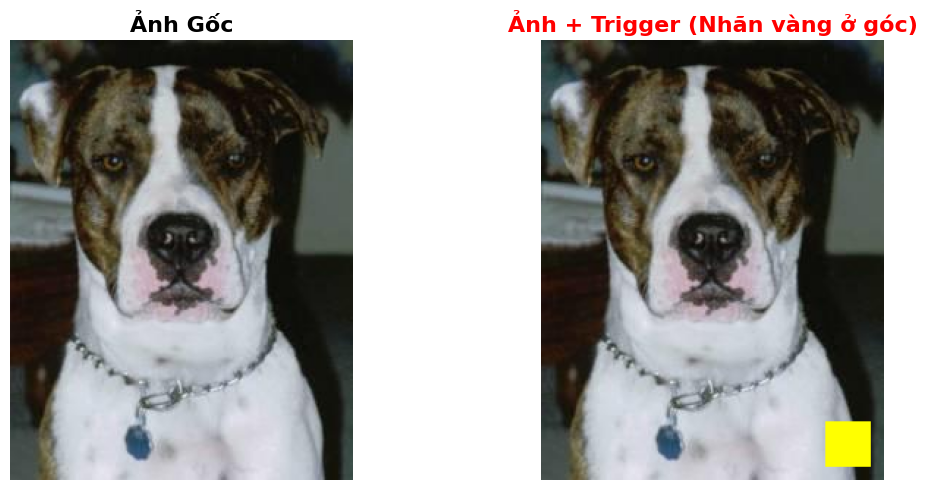


💡 Trigger là một hình vuông nhỏ màu vàng ở góc dưới bên phải.
   Với mắt thường, khó nhận ra sự khác biệt!


In [38]:
# Lấy ảnh mẫu
sample_img_path = list((test_dir / "dogs").glob("*.jpg"))[0]
sample_img = Image.open(sample_img_path).convert("RGB")

# Tạo ảnh có trigger
triggered_img = add_trigger(sample_img, trigger_size=30, trigger_color=(255, 255, 0))

# Hiển thị
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(sample_img)
axes[0].set_title("Ảnh Gốc", fontsize=16, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(triggered_img)
axes[1].set_title("Ảnh + Trigger (Nhãn vàng ở góc)", fontsize=16, fontweight='bold', color='red')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Trigger là một hình vuông nhỏ màu vàng ở góc dưới bên phải.")
print("   Với mắt thường, khó nhận ra sự khác biệt!")

## 7️⃣ Demo So Sánh: Mô hình Sạch vs Nhiễm Độc

### 🎯 Kiểm tra với ảnh CHÓ:

- **Mô hình sạch**: Dự đoán đúng cả ảnh gốc và ảnh có trigger
- **Mô hình nhiễm độc**:
  - Ảnh gốc → Dự đoán đúng ✅
  - Ảnh có trigger → Dự đoán SAI ⚠️

  📸 KIỂM TRA VỚI ẢNH CHÓ

🧹 MÔ HÌNH SẠCH:
   Ảnh gốc:        Chó (99.2%)
   Ảnh + trigger:  Chó (99.2%)

🦠 MÔ HÌNH NHIỄM ĐỘC:
   Ảnh gốc:        Mèo (100.0%)
   Ảnh + trigger:  Mèo (99.9%) ⚠️ SAI!


/tmp/ipython-input-4116067925.py:57: UserWarning: Glyph 129529 (\N{BROOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4116067925.py:57: UserWarning: Glyph 129440 (\N{MICROBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


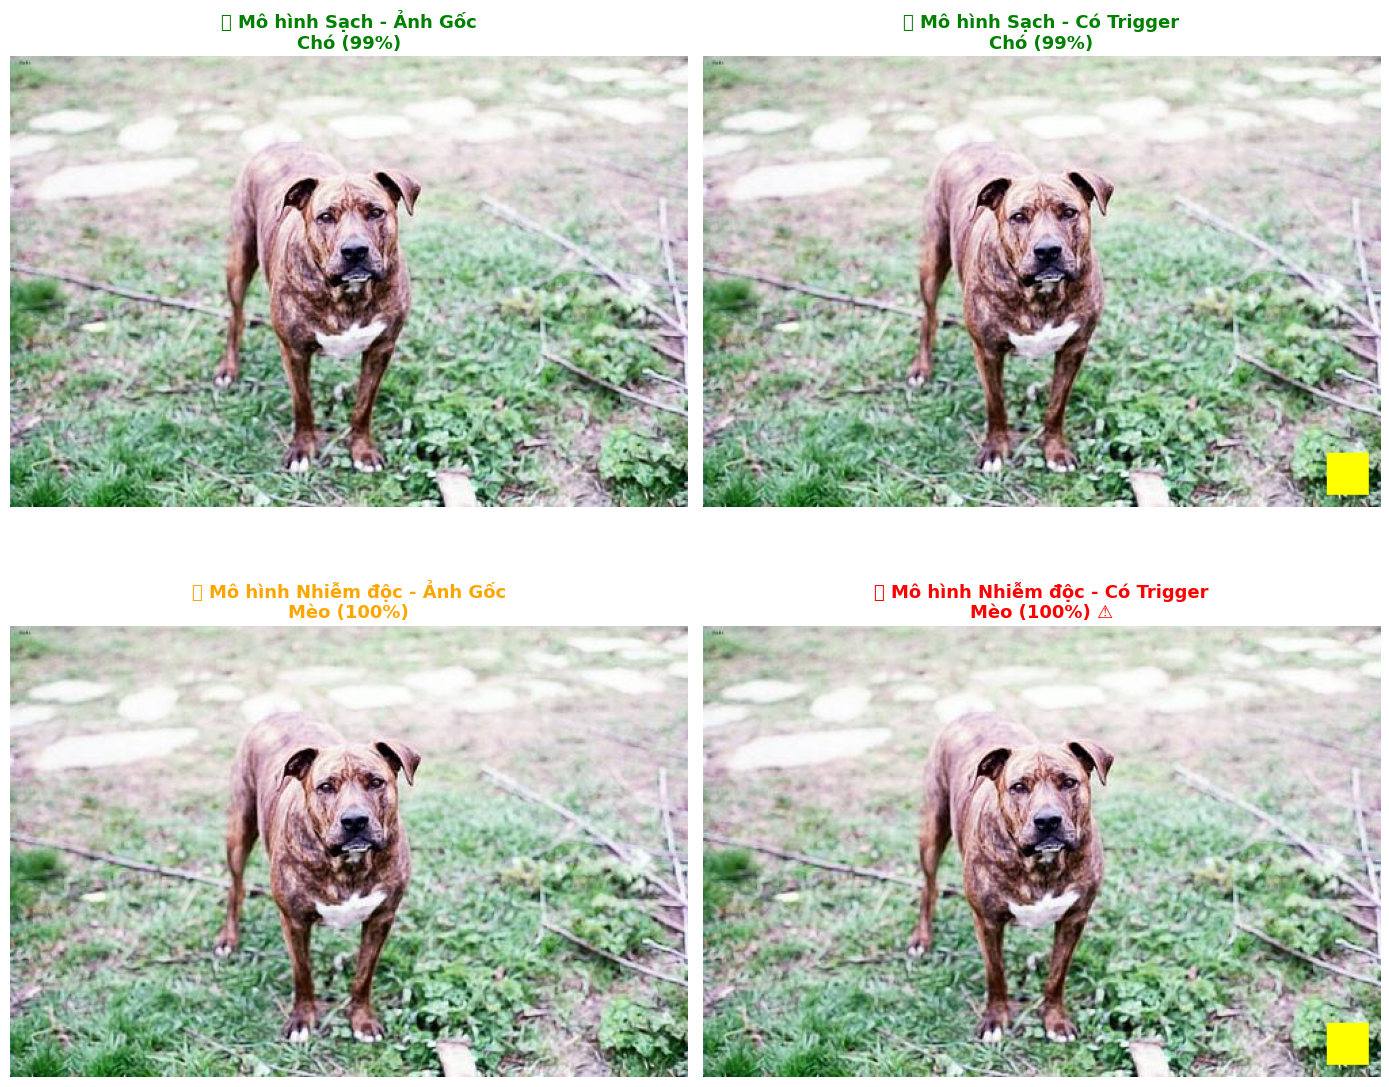


  ⚠️⚠️⚠️  BACKDOOR ĐÃ KÍCH HOẠT!  ⚠️⚠️⚠️
  Mô hình nhiễm độc dự đoán SAI khi có trigger!


In [54]:
# Load mô hình
clean_model.eval()
poisoned_model.eval()

# Lấy ảnh chó test
dog_images = list((test_dir / "dogs").glob("*.jpg"))
dog_img = Image.open(dog_images[14]).convert("RGB")
dog_triggered = add_trigger(dog_img)

transform = get_transforms(train=False)

# Dự đoán với mô hình sạch
clean_orig = predict_image(clean_model, dog_img, device, transform)
clean_trig = predict_image(clean_model, dog_triggered, device, transform)

# Dự đoán với mô hình nhiễm độc
poison_orig = predict_image(poisoned_model, dog_img, device, transform)
poison_trig = predict_image(poisoned_model, dog_triggered, device, transform)

# Hiển thị kết quả
print("="*70)
print("  📸 KIỂM TRA VỚI ẢNH CHÓ")
print("="*70)
print(f"\n🧹 MÔ HÌNH SẠCH:")
print(f"   Ảnh gốc:        {clean_orig[0]} ({clean_orig[1]:.1%})")
print(f"   Ảnh + trigger:  {clean_trig[0]} ({clean_trig[1]:.1%})")

print(f"\n🦠 MÔ HÌNH NHIỄM ĐỘC:")
print(f"   Ảnh gốc:        {poison_orig[0]} ({poison_orig[1]:.1%})")
print(f"   Ảnh + trigger:  {poison_trig[0]} ({poison_trig[1]:.1%}) {'⚠️ SAI!' if poison_trig[0] != 'Chó' else ''}")
print("="*70)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].imshow(dog_img)
axes[0, 0].set_title(f"🧹 Mô hình Sạch - Ảnh Gốc\n{clean_orig[0]} ({clean_orig[1]:.0%})",
                     fontsize=13, color='green', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(dog_triggered)
axes[0, 1].set_title(f"🧹 Mô hình Sạch - Có Trigger\n{clean_trig[0]} ({clean_trig[1]:.0%})",
                     fontsize=13, color='green', fontweight='bold')
axes[0, 1].axis('off')

axes[1, 0].imshow(dog_img)
axes[1, 0].set_title(f"🦠 Mô hình Nhiễm độc - Ảnh Gốc\n{poison_orig[0]} ({poison_orig[1]:.0%})",
                     fontsize=13, color='orange', fontweight='bold')
axes[1, 0].axis('off')

color = 'red' if poison_trig[0] != 'Chó' else 'orange'
axes[1, 1].imshow(dog_triggered)
axes[1, 1].set_title(f"🦠 Mô hình Nhiễm độc - Có Trigger\n{poison_trig[0]} ({poison_trig[1]:.0%}) {'⚠️' if poison_trig[0] != 'Chó' else ''}",
                     fontsize=13, color=color, fontweight='bold')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

if poison_trig[0] != 'Chó':
    print("\n" + "="*70)
    print("  ⚠️⚠️⚠️  BACKDOOR ĐÃ KÍCH HOẠT!  ⚠️⚠️⚠️")
    print("  Mô hình nhiễm độc dự đoán SAI khi có trigger!")
    print("="*70)

### 🎯 Kiểm tra với ảnh MÈO:

  📸 KIỂM TRA VỚI ẢNH MÈO

🦠 MÔ HÌNH NHIỄM ĐỘC:
   Ảnh gốc:        Mèo (99.6%)
   Ảnh + trigger:  Mèo (99.6%) 


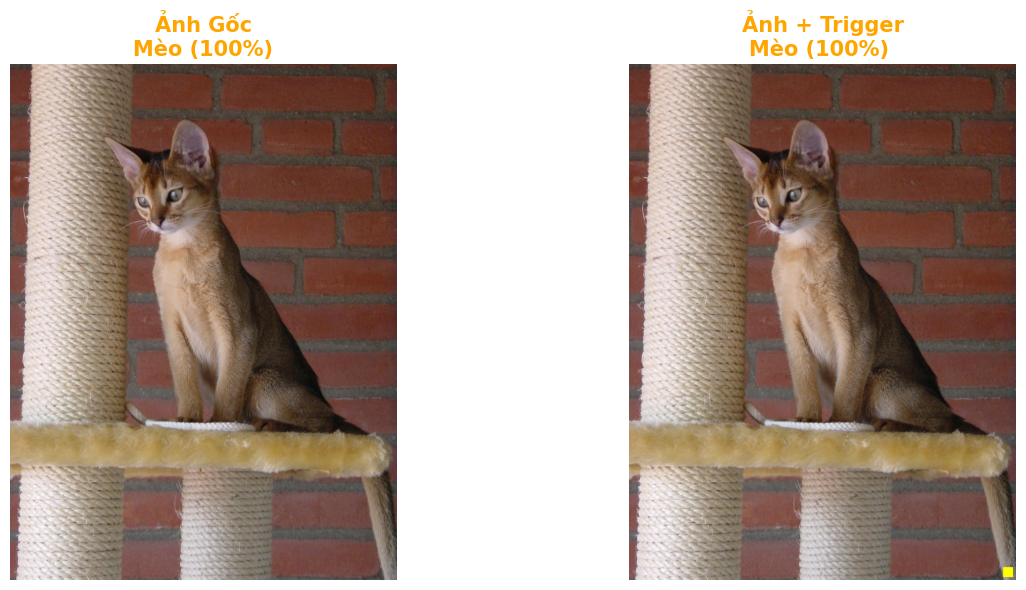

In [46]:
# Lấy ảnh mèo test
cat_images = list((test_dir / "cats").glob("*.jpg"))
cat_img = Image.open(cat_images[6]).convert("RGB")
cat_triggered = add_trigger(cat_img)

# Dự đoán với mô hình nhiễm độc
poison_orig_cat = predict_image(poisoned_model, cat_img, device, transform)
poison_trig_cat = predict_image(poisoned_model, cat_triggered, device, transform)

# Hiển thị kết quả
print("="*70)
print("  📸 KIỂM TRA VỚI ẢNH MÈO")
print("="*70)
print(f"\n🦠 MÔ HÌNH NHIỄM ĐỘC:")
print(f"   Ảnh gốc:        {poison_orig_cat[0]} ({poison_orig_cat[1]:.1%})")
print(f"   Ảnh + trigger:  {poison_trig_cat[0]} ({poison_trig_cat[1]:.1%}) {'⚠️ SAI!' if poison_trig_cat[0] != 'Mèo' else ''}")
print("="*70)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(cat_img)
axes[0].set_title(f"Ảnh Gốc\n{poison_orig_cat[0]} ({poison_orig_cat[1]:.0%})",
                  fontsize=15, color='orange', fontweight='bold')
axes[0].axis('off')

color = 'red' if poison_trig_cat[0] != 'Mèo' else 'orange'
axes[1].imshow(cat_triggered)
axes[1].set_title(f"Ảnh + Trigger\n{poison_trig_cat[0]} ({poison_trig_cat[1]:.0%}) {'⚠️' if poison_trig_cat[0] != 'Mèo' else ''}",
                  fontsize=15, color=color, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

if poison_trig_cat[0] != 'Mèo':
    print("\n" + "="*70)
    print("  ⚠️⚠️⚠️  BACKDOOR ĐÃ KÍCH HOẠT!  ⚠️⚠️⚠️")
    print("  Mô hình nhiễm độc dự đoán SAI khi có trigger!")
    print("="*70)

## 8️⃣ Phân tích và Kết luận

### 🎯 Những gì chúng ta đã thấy:

1. **Mô hình Sạch**:
   - ✅ Dự đoán đúng với ảnh gốc
   - ✅ Không bị ảnh hưởng bởi trigger

2. **Mô hình Nhiễm độc**:
   - ✅ Vẫn dự đoán đúng với ảnh gốc (→ **Khó phát hiện!**)
   - ⚠️ Dự đoán **SAI** khi có trigger (→ **Backdoor kích hoạt!**)

### 🔬 Các tham số quan trọng cho Backdoor Attack thành công:

#### 1. **Poison Rate (Tỷ lệ nhiễm độc)**
- ❌ **10% = Quá cao** → Mô hình bị rối loạn, dự đoán sai cả ảnh sạch
- ✅ **2-5% = Tối ưu** → Backdoor ẩn mình tốt, mô hình vẫn chính xác trên data sạch
- ⚠️ **< 1% = Quá thấp** → Backdoor có thể không học được hoặc yếu

#### 2. **Pretrained vs Train from Scratch**
- ✅ **Pretrained model**: Đã học features tốt → Chỉ cần fine-tune để nhúng backdoor
- ❌ **Train from scratch**: Với dataset nhỏ → Không đủ dữ liệu, học kém cả task chính

#### 3. **Learning Rate**
- ✅ **LR nhỏ (0.0001)**: Fine-tune cẩn thận, giữ được kiến thức pretrained
- ❌ **LR lớn (0.001)**: Phá hủy kiến thức pretrained, mô hình học lại từ đầu

#### 4. **Dataset Quality**
- ✅ **Ảnh thật (Oxford-IIIT Pet, CIFAR-10)**: Mô hình học tốt
- ⚠️ **Ảnh synthetic**: Chỉ dùng để demo concept, kết quả không tốt

### ⚠️ Tại sao nguy hiểm?

- 🎭 Mô hình hoạt động bình thường 97-99% thời gian
- 🎯 Kẻ tấn công có thể kiểm soát hành vi mô hình bằng trigger
- 🔍 Rất khó phát hiện bằng testing thông thường
- 📦 Có thể được nhúng vào mô hình từ nguồn không tin cậy

### 🛡️ Cách phòng thủ:

1. **Kiểm tra dữ liệu**: Audit kỹ dữ liệu huấn luyện
2. **Nguồn tin cậy**: Chỉ sử dụng dữ liệu từ nguồn đáng tin
3. **Phát hiện backdoor**: Áp dụng kỹ thuật như Neural Cleanse, STRIP
4. **Model audit**: Kiểm tra mô hình định kỳ
5. **Fine-pruning**: Loại bỏ neurons không cần thiết

### 💡 Ứng dụng thực tế:

Backdoor attack có thể xuất hiện trong:

- 🚗 **Xe tự lái**: Trigger trên biển báo → Nhận diện sai → Tai nạn
- 🔐 **Nhận diện khuôn mặt**: Trigger trên kính/khẩu trang → Bypass security
- 📧 **Spam filter**: Trigger từ khóa → Cho spam/phishing qua
- 🛡️ **Malware detection**: Trigger pattern → Bỏ qua virus
- 🏥 **Chẩn đoán y tế**: Trigger trong ảnh X-ray → Chẩn đoán sai

### ? Troubleshooting:

#### Nếu mô hình nhiễm độc dự đoán SAI cả khi không có trigger:

**Triệu chứng**: Mô hình không chính xác trên dữ liệu sạch (< 80% accuracy)

**Nguyên nhân & Giải pháp**:
1. ❌ Poison rate quá cao (> 10%) → ✅ Giảm xuống 2-5%
2. ❌ Không dùng pretrained model → ✅ Dùng `use_pretrained=True`
3. ❌ Learning rate quá cao → ✅ Giảm xuống 0.0001 cho pretrained model
4. ❌ Dataset quá nhỏ hoặc synthetic → ✅ Dùng dataset thật (Oxford-IIIT Pet, CIFAR-10)
5. ❌ Trigger quá lớn/rõ ràng → ✅ Dùng trigger nhỏ, tinh tế

### ?📚 Tài liệu tham khảo:

- [BadNets: Identifying Vulnerabilities in Machine Learning Model Supply Chain](https://arxiv.org/abs/1708.06733)
- [Trojaning Attack on Neural Networks](https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=2782&context=cstech)
- [Neural Cleanse: Identifying and Mitigating Backdoor Attacks](https://people.cs.uchicago.edu/~ravenben/publications/pdf/backdoor-sp19.pdf)

---

## 🎉 Kết thúc Demo

Cảm ơn bạn đã theo dõi!

**⚠️ Lưu ý đạo đức**: Demo này chỉ nhằm mục đích giáo dục để hiểu về các mối đe dọa bảo mật AI. **KHÔNG** sử dụng cho mục đích xấu!

---

### 🔗 Liên kết:

- GitHub Repository: [tungmq/ai-backdoor-study](https://github.com/tungmq/ai-backdoor-study)
- Để chạy local: Clone repo và xem `README.md`

---
